In [12]:
import numpy as np
import nibabel as nib
import os

import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams

from sklearn.preprocessing import scale
import pandas as pd

from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold

from sklearn.metrics import mean_absolute_error as MAE


def make_age_list(files, age_df):
    age_list = []
    for file in files:
        ID = file[17:25]
        age_list.append(df.loc[df[0] == ID][1].values[0])
    return age_list

In [2]:
#reading white matter and age files

files = os.listdir('wm_data')
df = pd.read_csv('original_participant_data.tsv', header=None, sep='\t')
ages = make_age_list(files,df)

data = np.zeros((len(files), 121,145,121))
for sub in range(len(files)):
    img = nib.load('wm_data/'+files[sub])
    data[sub,...] = img.get_data()

# Age distribution:

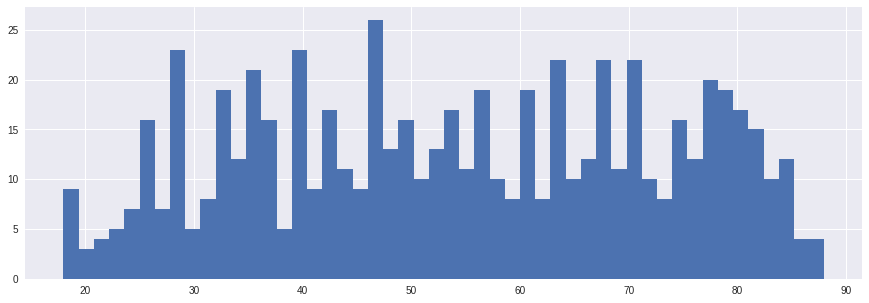

In [3]:
rcParams['figure.figsize'] = 15, 5

plt.hist(ages, 50)
plt.show()

# It looks like scans are not rotated or shifted much:

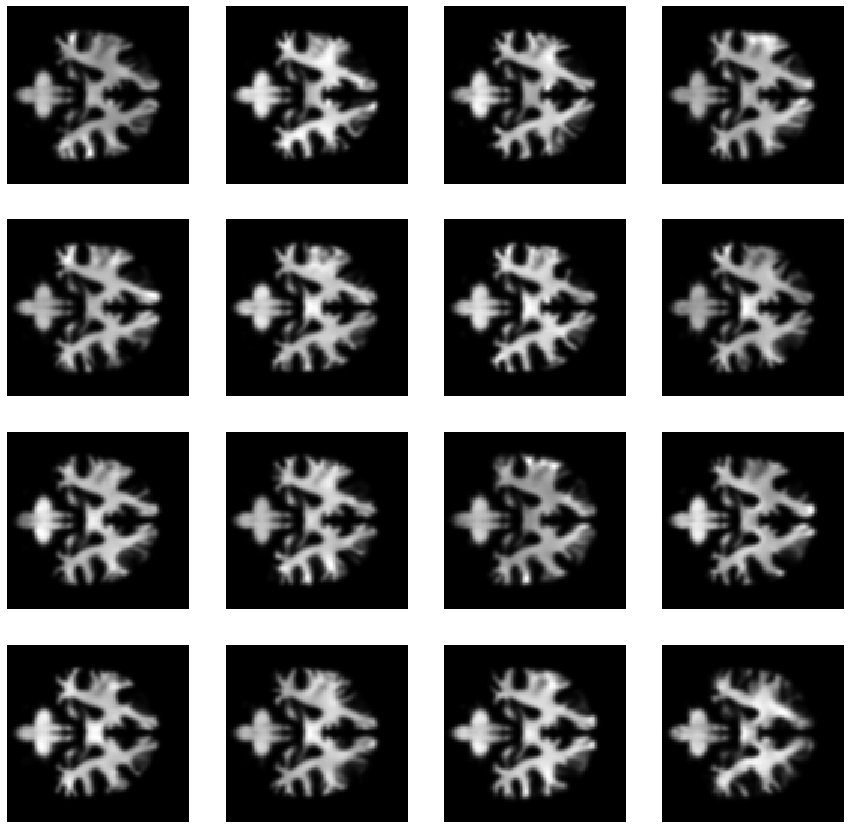

In [4]:
#plotting middle axial slice for 16 subjects
rcParams['figure.figsize'] = 15, 15

f, ax = plt.subplots(4,4)
for sub in range(16):
    sns.heatmap(data[sub,:,60,:], cmap = 'gray', xticklabels = False, yticklabels = False, ax = ax[sub//4, sub%4], 
                cbar = False)
plt.show()

In [5]:
#averaging densities on consecutive slices
n_subjects = len(files)
averaged_densities = np.zeros((n_subjects, 145, 3))

for sub in range(n_subjects):
    img = nib.load('wm_data/'+files[sub])
    data = img.get_data()
    averaged_densities[sub, :121, 0] = np.mean(data,(0,1))
    averaged_densities[sub, :, 1] = np.mean(data,(0,2))
    averaged_densities[sub, :121, 2] = np.mean(data,(1,2))

# Data is not perfectly normalised, what can be seen by plotting average densities of consecutive slices. Also: there are two outliers.

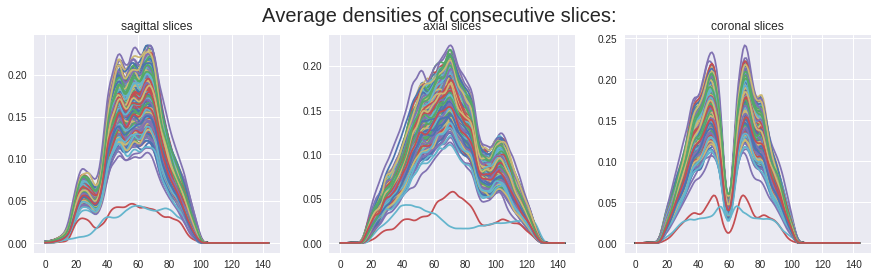

In [6]:
rcParams['figure.figsize'] = 15,4

f, ax = plt.subplots(1,3)
labels = ['sagittal slices', 'axial slices', 'coronal slices']
for i in range(3):
    ax[i].plot(averaged_densities[:,:,i].T)
    ax[i].set_title(labels[i])

plt.suptitle('Average densities of consecutive slices:', fontsize=20)

plt.show()

# After normalisation we can see even clearer that data is almost perfectly coalligned. Outliers are still visible though.

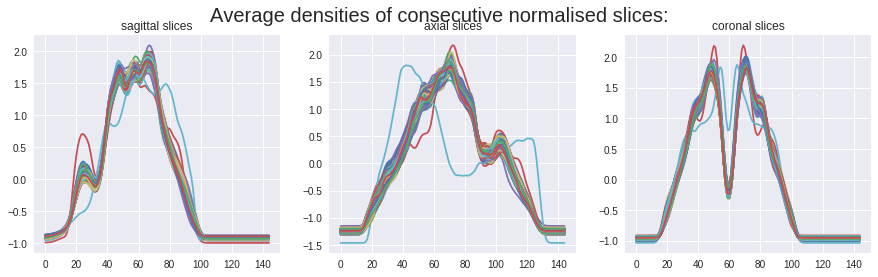

In [7]:
rcParams['figure.figsize'] = 15,4

f, ax = plt.subplots(1,3)
labels = ['sagittal slices', 'axial slices', 'coronal slices']
for i in range(3):
    ax[i].plot(scale(averaged_densities[:,:,i], axis = 1).T)
    ax[i].set_title(labels[i])

plt.suptitle('Average densities of consecutive normalised slices:', fontsize=20)

plt.show()

# Lets check how predictive are above plots:

In [8]:
sh = averaged_densities.shape
density_features = averaged_densities.reshape(sh[0],sh[1]*sh[2])
normalised_density_features = np.zeros((density_features.shape))
for i in range(3):
    normalised_density_features[:,145*i:145*(i+1)] = scale(averaged_densities[:,:,i], axis = 1)

In [ ]:
model = Ridge(10**(-4))
n_folds = 10
predicted_ages = np.zeros(len(ages))
kf = KFold(n_folds)
for i_train, i_test in tqdm(kf.split(density_features, ages)):
    model.fit(density_features[i_train,:], np.array(ages)[i_train])
    predicted_ages[i_test] = model.predict(density_features[i_test,:])
print(MAE(ages,predicted_ages))

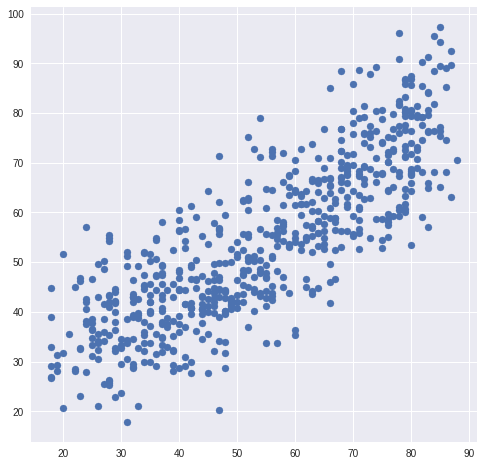

In [56]:
rcParams['figure.figsize'] = 8,8

plt.scatter(ages, predicted_ages)
plt.show()